# Project 4

## Group Number 6

### Team Members
- Baraa Nidal Ghannoum
- Tom Mantel
- Mubarik Omar Ali Abdi


Abstract:


Intro:

Topic 1

Task 0

In [1]:
# Task 0: Install mw_plot library
!pip install mw_plot

In [2]:
import mw_plot
print("mw_plot successfully installed and imported!")
#to make srure the library is installed and working.


mw_plot successfully installed and imported!


Task 1

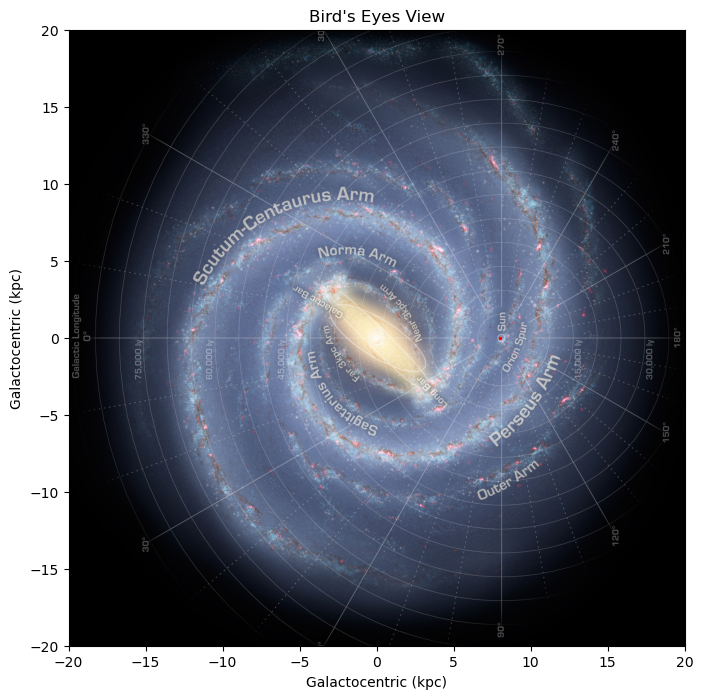

In [3]:
# Task 1: Create a simple plot using mw_plot
import numpy as np
from astropy import units as u
from mw_plot import MWFaceOn

mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)

mw1.title = "Bird's Eyes View"
mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)

#instaleed the package and reproduced the plot of the milky way successfully/straight from mw_plot's webpage see reference:1


Task 2

As we need to measure the brightness of the galaxy at different radiuses, we go to data reduction, aka 2-D to 1-D curves. We convert the RGB into luminance, and convert the pixel positions to galactrocenctric coordinates, which should in the end showcase a graph coresponding brightness vs radius.

min: 0 max: 255


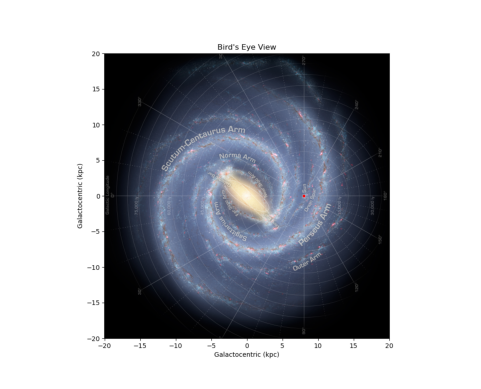

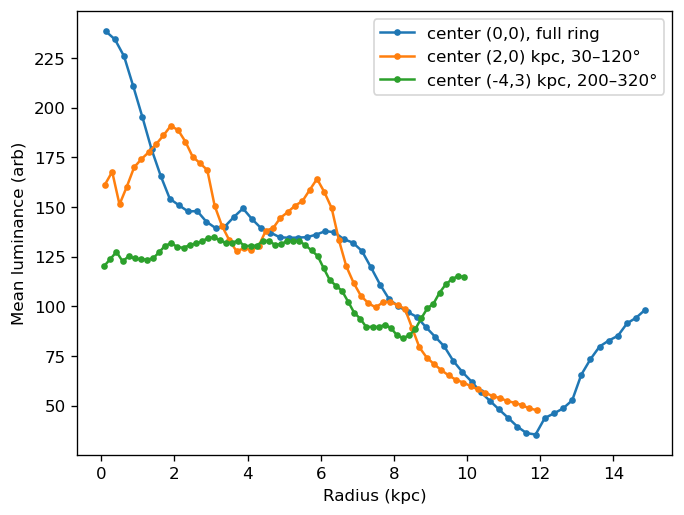

In [5]:
# Task 2: building the visualizations


import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv

def render_faceon(radius=20*u.kpc, figsize=(10,8)):
    # Let MWFaceOn create and use its own figure, like in Task 1
    mw = MWFaceOn(
        radius=radius,
        unit=u.kpc,
        coord="galactocentric",
        annotation=True,
        figsize=figsize,
    )

    mw.title = "Bird's Eye View"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=10)

    # Get the figure MWFaceOn is actually using
    fig = plt.gcf()
    fig.canvas.draw()

    # Read pixels from that figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img_rgba = buf.reshape(h, w, 4)

    # Drop alpha → RGB
    img = img_rgba[..., :3].copy()

    plt.close(fig)

    extent = (-radius.value, radius.value, -radius.value, radius.value)
    return img, extent

def radial_profile_sector(rgb, extent, center=(0,0), rmax=12.0, nrbins=60,
                          theta_deg=(0, 360)):
    # colour -> grayscale
    lum = (0.2126*rgb[...,0] + 0.7152*rgb[...,1] + 0.0722*rgb[...,2]).astype(float)

    xmin, xmax, ymin, ymax = extent
    h, w = lum.shape
    xs = np.linspace(xmin, xmax, w)
    ys = np.linspace(ymin, ymax, h)
    X, Y = np.meshgrid(xs, ys)

    xc, yc = center
    R = np.sqrt((X-xc)**2 + (Y-yc)**2)
    T = (np.degrees(np.arctan2(Y-yc, X-xc)) + 360) % 360

    t1, t2 = theta_deg
    if t1 <= t2:
        sector = (T>=t1) & (T<=t2)
    else:
        sector = (T>=t1) | (T<=t2)

    r_edges = np.linspace(0, rmax, nrbins+1)
    prof = np.zeros(nrbins)
    for i in range(nrbins):
        mask = (R>=r_edges[i]) & (R<r_edges[i+1]) & sector
        prof[i] = lum[mask].mean() if np.any(mask) else np.nan
    r_centers = 0.5*(r_edges[:-1] + r_edges[1:])
    return r_centers, prof

# rendering the image once
rgb_array, extent = render_faceon(radius=20*u.kpc)

print("min:", rgb_array.min(), "max:", rgb_array.max())
plt.imshow(rgb_array); plt.axis("off"); plt.show()

# three different profiles (different centers, radiuses, sectors)
configs = [
    {"center":(0,0),   "rmax":15, "theta_deg":(0,360),  "label":"center (0,0), full ring"},
    {"center":(2,0),   "rmax":12, "theta_deg":(30,120), "label":"center (2,0) kpc, 30–120°"},
    {"center":(-4,3),  "rmax":10, "theta_deg":(200,320),"label":"center (-4,3) kpc, 200–320°"},
]

plt.figure(dpi=120)

for cfg in configs:
    cfg_clean = {k: v for k, v in cfg.items() if k != "label"}
    r, y = radial_profile_sector(rgb_array, extent, **cfg_clean)
    plt.plot(r, y, marker=".", label=cfg["label"])

plt.xlabel("Radius (kpc)")
plt.ylabel("Mean luminance (arb)")
plt.legend()
plt.show()

Task 3

We will capture and render figures directly from matplotlib, and it will return a numpy array representing the image.

(1200, 1500, 3) uint8


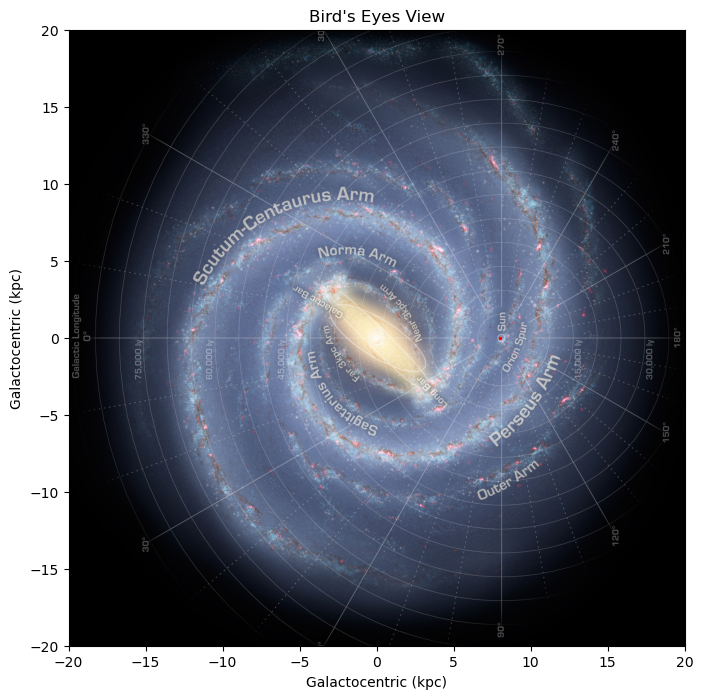

In [25]:
# Do note that we need the rgb array to be named as rgb_array for the code to work

#calling the renderer from task 2 into the code

rgb_array, extent = render_faceon(radius=20*u.kpc)
print(rgb_array.shape, rgb_array.dtype)

Task 4

Each RGB channel (0–255) is broken into 4 ranges

Every pixel gets mapped to a category number (0 to 63)

In [14]:
# A

def color_bins(rgb, k=4):
    # rgb is advised to be in the uint8 format.
    bins = np.linspace(0, 256, k+1)
    r = np.digitize(rgb[...,0], bins) - 1
    g = np.digitize(rgb[...,1], bins) - 1
    b = np.digitize(rgb[...,2], bins) - 1
    #this is combined into a single integer label
    labels = (r * k + g) * k + b
    return labels

labels_bins = color_bins(rgb_array, k=4)  # categories per channel

Task 5

Rendered image shape: (800, 1000, 3) dtype: uint8


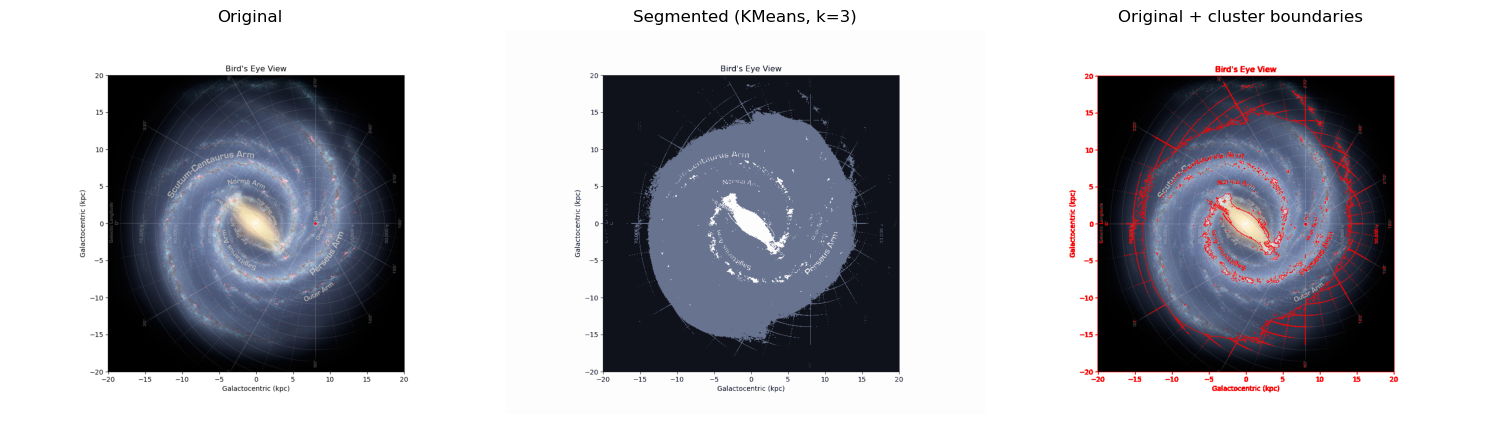

In [25]:
# Task 5: Apply K-means clustering to Milky Way image data

from sklearn.cluster import KMeans

def kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=None, show=True):
    # Reshape it 
    h, w, _ = rgb_array.shape
    pixels = rgb_array.reshape(-1, 3).astype(float) / 255.0

    # Optionally subsample for speed
    if subsample is not None and subsample < pixels.shape[0]:
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(pixels.shape[0], size=subsample, replace=False)
        sample = pixels[sample_idx]
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(sample)
        labels = kmeans.predict(pixels)
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(pixels)
        labels = kmeans.labels_

    # Build segmented image using cluster centers as colors
    centers = (kmeans.cluster_centers_ * 255).astype(np.uint8)
    segmented = centers[labels].reshape(h, w, 3)

    # Build label image and compute simple boundaries
    label_img = labels.reshape(h, w)
    boundary = np.zeros((h, w), dtype=bool)
    boundary[:, :-1] |= label_img[:, :-1] != label_img[:, 1:]
    boundary[:-1, :] |= label_img[:-1, :] != label_img[1:, :]

    # Overlay boundaries on original (red lines)
    overlay = rgb_array.copy().astype(np.uint8)
    overlay[boundary] = np.array([255, 0, 0], dtype=np.uint8)

    if show:
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        axes[0].imshow(rgb_array)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(segmented)
        axes[1].set_title(f"Segmented (KMeans, k={n_clusters})")
        axes[1].axis("off")

        axes[2].imshow(overlay)
        axes[2].set_title("Original + cluster boundaries")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return segmented, label_img, overlay


# Example usage:
# 1) Render the face-on image (from previously defined function)
rgb_array, extent = render_faceon(radius=20*u.kpc)
print("Rendered image shape:", rgb_array.shape, "dtype:", rgb_array.dtype)

# 2) Segment with KMeans (use subsample for large images, e.g., subsample=100000)
segmented, labels, overlay = kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=100000)


Task 6

build a colour for each cluster from its centroid, better than randomly assigning colours to each cluster because:
If you color each cluster with a random color (e.g. cyan, pink, neon green):

-cluster 0 might represent the dark background, but appear red
-cluster 1 might represent the bright bulge, but appear black
-cluster 2 might represent the blue spiral arms, but appear yellow

In [26]:
import numpy as np
import matplotlib.pyplot as plt
palette = centroids

seg_rgb = palette[clustered_image]                       # (H,W,3) uint8

alpha = 0.5                                              
overlay = (alpha*seg_rgb + (1-alpha)*rgb_array).astype(np.uint8)

plt.figure(figsize=(12,4), dpi=120)
plt.subplot(1,3,1); plt.imshow(rgb_array);   plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(seg_rgb);     plt.title("Clusters colorized"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay);     plt.title("Overlay (Task 6)");   plt.axis("off")
plt.show()

NameError: name 'centroids' is not defined

Task 7



We will compare the results from task 4 using intertia and solhouette scores. This allows us to understand how the galaxy's structure appear at different clustering levels, and will help us determine a reasonable number of clusters for segmentation.

In [ ]:
# Task 7: Evaluate K-means clustering with inertia and silhouette scores

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

H, W, _ = rgb_array.shape
pixels = rgb_array.reshape(-1,3).astype(float)
idx = np.random.choice(pixels.shape[0], size=min(50_000, pixels.shape[0]), replace=False)
sample = pixels[idx] / 255.0

Ks = [2,3,4,5,6]
inertias, sils = [], []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto")
    km.fit(sample)
    inertias.append(km.inertia_)
    # silhouette needs >=2 clusters and all points should not be identical
    try:
        sils.append(silhouette_score(sample, km.predict(sample)))
    except Exception:
        sils.append(np.nan)

plt.figure(dpi=120)
plt.plot(Ks, inertias, marker="o"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow (Task 7)")
plt.show()

plt.figure(dpi=120)
plt.plot(Ks, sils, marker="o"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette vs K (Task 7)")
plt.show()

for K in [3,5]:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(pixels/255.0)
    seg = km.labels_.reshape(H, W)
    seg_rgb = (km.cluster_centers_*255).astype(np.uint8)[seg]
    overlay = (0.5*seg_rgb + 0.5*rgb_array).astype(np.uint8)

    plt.figure(figsize=(8,3), dpi=120)
    plt.subplot(1,2,1); plt.imshow(seg_rgb); plt.title(f"K={K} clusters"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"K={K} overlay");  plt.axis("off")
    plt.show()

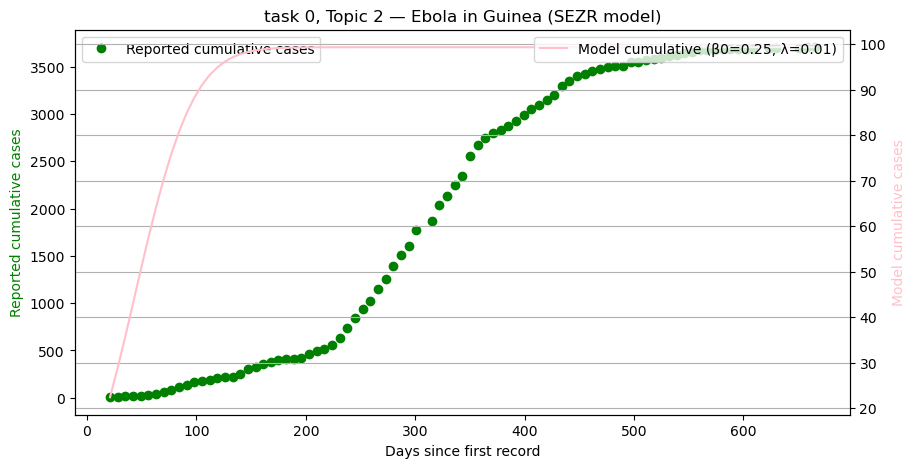

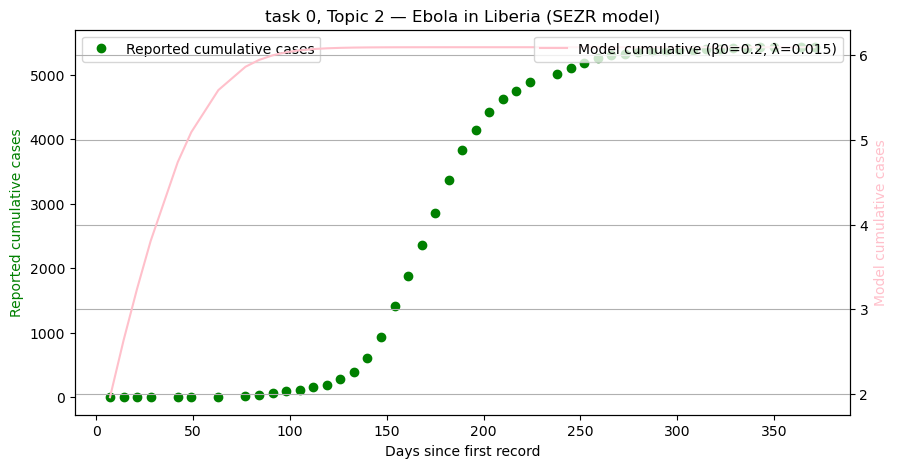

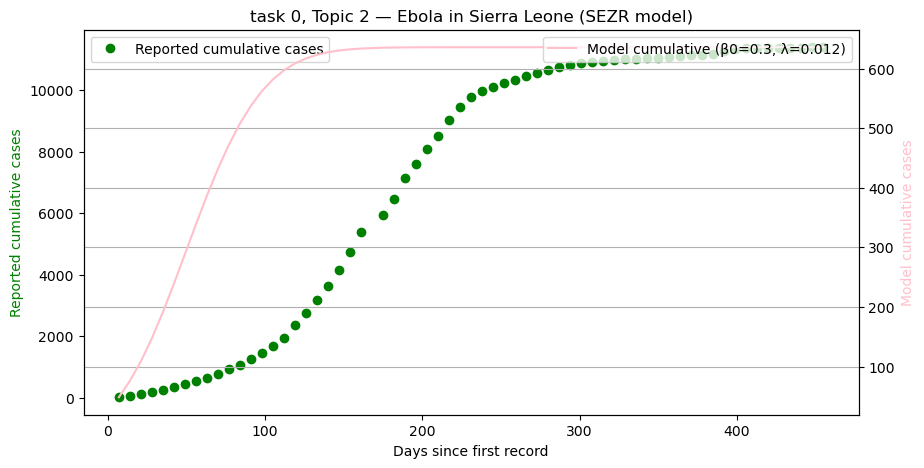

In [12]:
#task2_0:
import pandas as pd
import math

#Parameters as shown in the project text 
N = 10_000_000
gamma = 1.0 / 7.0
sigma = 1.0 / 9.7

#SEZR model 
def sezr_rhs(y, t, beta0, lam):
    S, E, Z, R = y
    beta_t = beta0 * math.exp(-lam * t)
    dS = -beta_t * S * Z / N
    dE = beta_t * S * Z / N - sigma * E
    dZ = sigma * E - gamma * Z
    dR = gamma * Z
    return np.array([dS, dE, dZ, dR])

def rk4_step(f, y, t, dt, *args):
    k1 = f(y, t, *args)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt, *args)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt, *args)
    k4 = f(y + dt*k3, t + dt, *args)
    return y + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def integrate_sezr(beta0, lam, t_end, new_cases, dt=0.25):
    tgrid = np.arange(0, t_end+dt, dt)
    Z0 = max(1.0, new_cases[0])
    y0 = np.array([N - Z0, 0.0, Z0, 0.0])
    Y = np.zeros((len(tgrid), 4))
    Y[0] = y0
    for i in range(len(tgrid)-1):
        Y[i+1] = rk4_step(sezr_rhs, Y[i], tgrid[i], dt, beta0, lam)
        Y[i+1] = np.maximum(Y[i+1], 0)
    return tgrid, Y

#Files for the three countries
files = {
    "Guinea": "data/ebola_cases_guinea.dat",
    "Liberia": "data/ebola_cases_liberia.dat",
    "Sierra Leone": "data/ebola_cases_sierra_leone.dat"
}

#Manual parameters(if needed to be tuned separately)
params = {
    "Guinea": (0.25, 0.01),
    "Liberia": (0.20, 0.015),
    "Sierra Leone": (0.30, 0.012)
}

#Loop over countries
for country, fname in files.items():
    df = pd.read_csv(fname, sep=None, engine="python")
    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)
    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)
    cum_cases = np.cumsum(new_cases)

    beta0, lam = params[country]
    tgrid, Y = integrate_sezr(beta0, lam, days[-1], new_cases)
    S = np.interp(days, tgrid, Y[:,0])
    cum_model = N - S

    #Plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()

    ax1.plot(days, cum_cases, "o", color="green", label="Reported cumulative cases")
    ax1.set_ylabel("Reported cumulative cases", color="green")

    ax2.plot(days, cum_model, "-", color="pink", label=f"Model cumulative (β0={beta0}, λ={lam})")
    ax2.set_ylabel("Model cumulative cases", color="pink")

    ax1.set_xlabel("Days since first record")
    ax1.set_title(f"task 0, Topic 2 — Ebola in {country} (SEZR model)")

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.grid(True)
    plt.show()


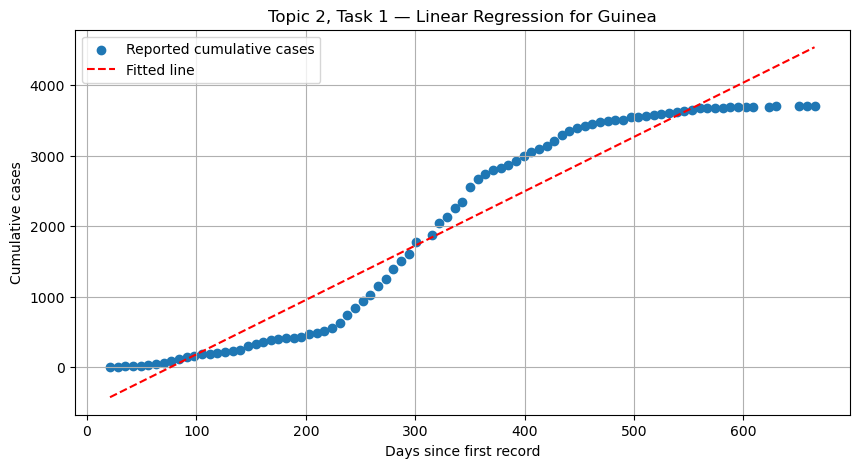

Guinea: slope=7.71, intercept=-589.07


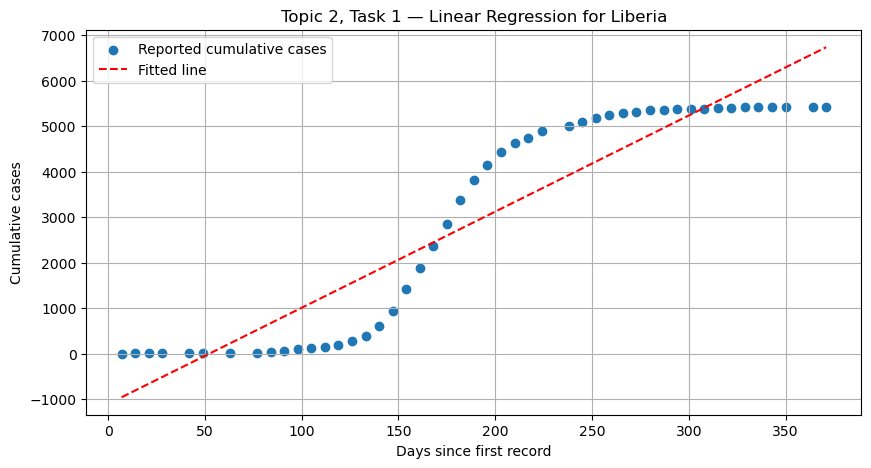

Liberia: slope=21.14, intercept=-1107.30


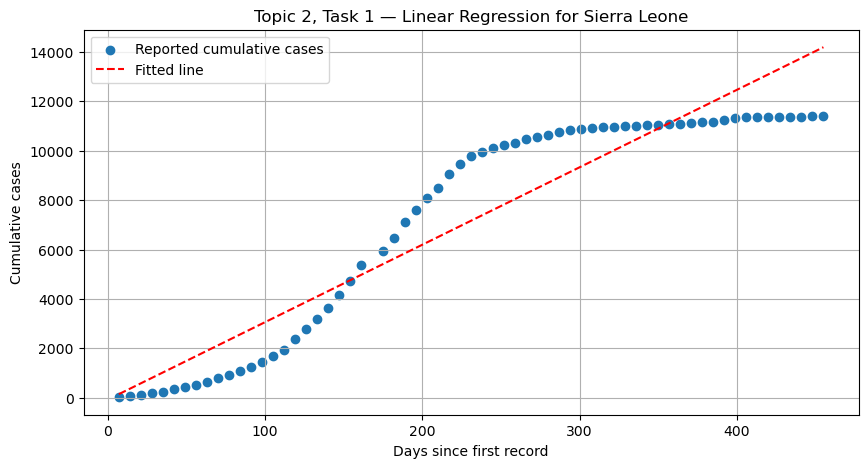

Sierra Leone: slope=31.36, intercept=-75.54


In [14]:
from sklearn.linear_model import LinearRegression

for country, fname in files.items():

    # Load dataset
    df = pd.read_csv(fname, sep=None, engine="python")

    # Extract x and y data
    x = pd.to_numeric(df.iloc[:, 1], errors="coerce").astype(float).values
    new_cases = pd.to_numeric(df.iloc[:, 2], errors="coerce").fillna(0).astype(float).values
    y = np.cumsum(new_cases)

    # Prepare data for sklearn
    X = x.reshape(-1, 1)

    # Create and fit model
    model = LinearRegression()
    model.fit(X, y)

    # Predict values
    y_pred = model.predict(X)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, label="Reported cumulative cases")
    plt.plot(x, y_pred, color="red", linestyle="--", label="Fitted line")

    plt.xlabel("Days since first record")
    plt.ylabel("Cumulative cases")
    plt.title(f"Topic 2, Task 1 — Linear Regression for {country}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print model parameters
    print(f"{country}: slope={model.coef_[0]:.2f}, intercept={model.intercept_:.2f}")


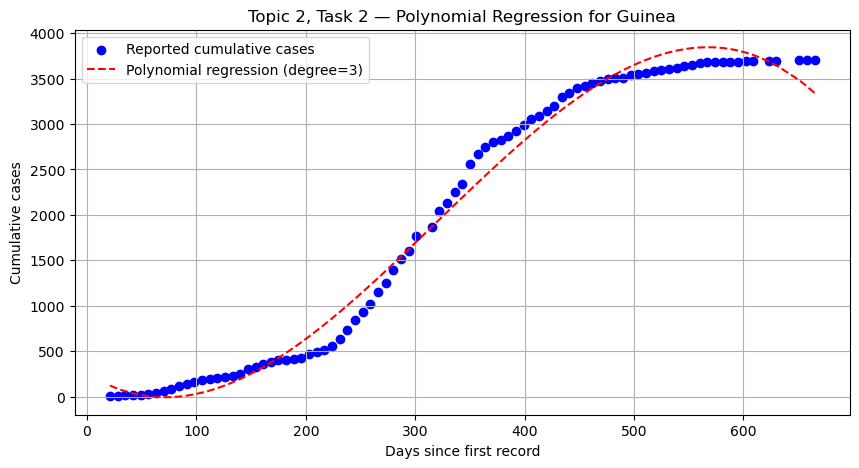

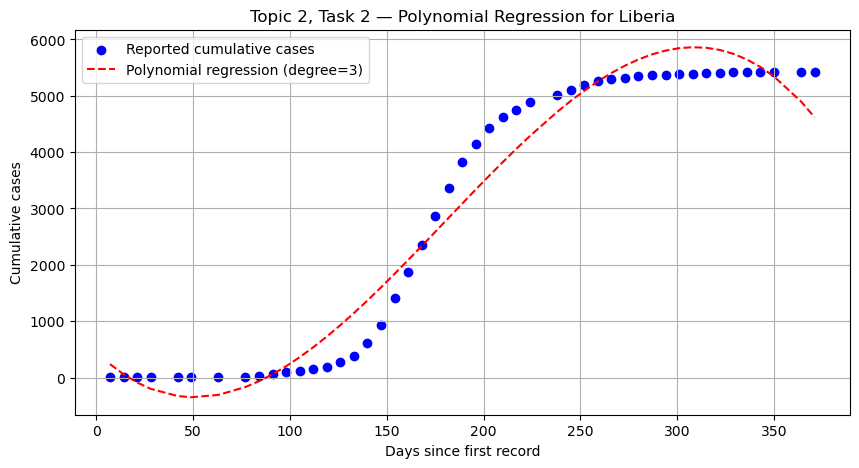

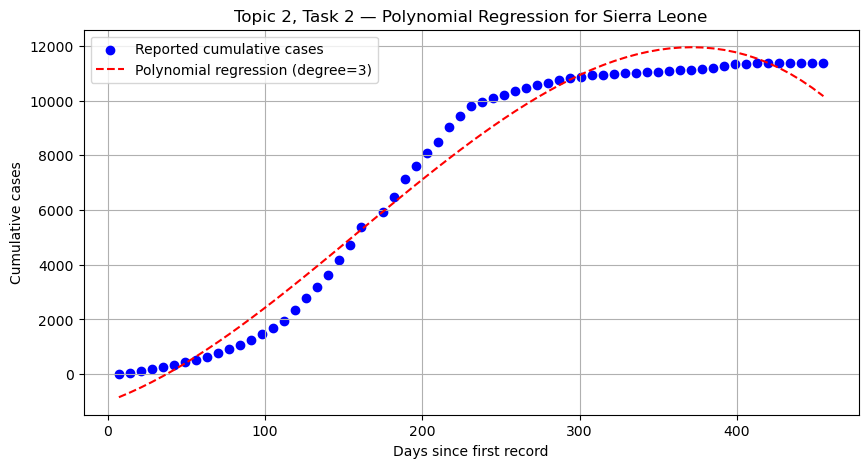

In [20]:
#task:2_2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


#Polynomial degree
degree = 3

for country, fname in files.items():
    # Load data
    df = pd.read_csv(fname, sep=None, engine="python")
    days = pd.to_numeric(df.iloc[:,1], errors="coerce").values.astype(float)
    new_cases = pd.to_numeric(df.iloc[:,2], errors="coerce").fillna(0).values.astype(float)
    cum_cases = np.cumsum(new_cases)

    # Reshape for sklearn
    X = days.reshape(-1, 1)
    y = cum_cases

    # Polynomial regression pipeline
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot
    plt.figure(figsize=(10,5))
    plt.scatter(days, cum_cases, color="blue", label="Reported cumulative cases")
    plt.plot(days, y_pred, color="red", linestyle="--", label=f"Polynomial regression (degree={degree})")

    plt.xlabel("Days since first record")
    plt.ylabel("Cumulative cases")
    plt.title(f"Topic 2, Task 2 — Polynomial Regression for {country}")
    plt.legend()
    plt.grid(True)
    plt.show()


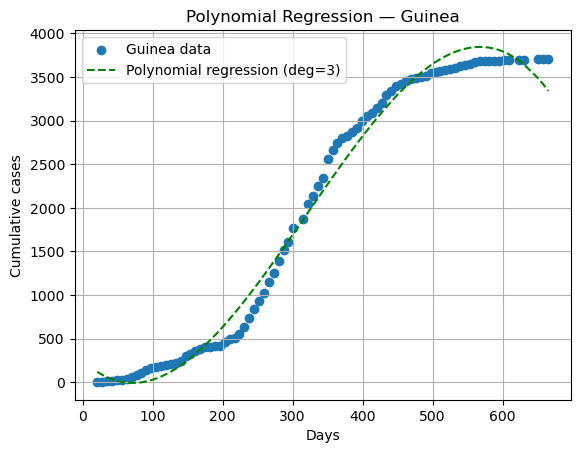

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

class PolynomialFit:
    def __init__(self, days, cum_cases, country, degree=3):
        self.days = days.reshape(-1,1)
        self.cum_cases = cum_cases
        self.country = country
        self.degree = degree
        self.model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    def fit(self):
        self.model.fit(self.days, self.cum_cases)

    def plot(self):
        y_pred = self.model.predict(self.days)
        plt.scatter(self.days, self.cum_cases, label=f"{self.country} data")
        plt.plot(self.days, y_pred, color="green", linestyle="--",
                 label=f"Polynomial regression (deg={self.degree})")
        plt.xlabel("Days")
        plt.ylabel("Cumulative cases")
        plt.title(f"Polynomial Regression — {self.country}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage for Guinea
poly_fit = PolynomialFit(days, cum_cases, "Guinea", degree=3)
poly_fit.fit()
poly_fit.plot()


## References


[1] Milky Way Plot Documentation (Face-on View).  
https://milkyway-plot.readthedocs.io/en/stable/matplotlib_faceon.html
